Epoch 1/15, Last Batch Loss: 0.6556
Epoch 2/15, Last Batch Loss: 0.9685
Epoch 3/15, Last Batch Loss: 0.6804
Epoch 4/15, Last Batch Loss: 1.1448
Epoch 5/15, Last Batch Loss: 0.5430
Epoch 6/15, Last Batch Loss: 0.2377
Epoch 7/15, Last Batch Loss: 0.6978
Epoch 8/15, Last Batch Loss: 0.3047
Epoch 9/15, Last Batch Loss: 0.6231
Epoch 10/15, Last Batch Loss: 0.0599
Epoch 11/15, Last Batch Loss: 0.3326
Epoch 12/15, Last Batch Loss: 0.3654
Epoch 13/15, Last Batch Loss: 0.1009
Epoch 14/15, Last Batch Loss: 0.0582
Epoch 15/15, Last Batch Loss: 0.3266


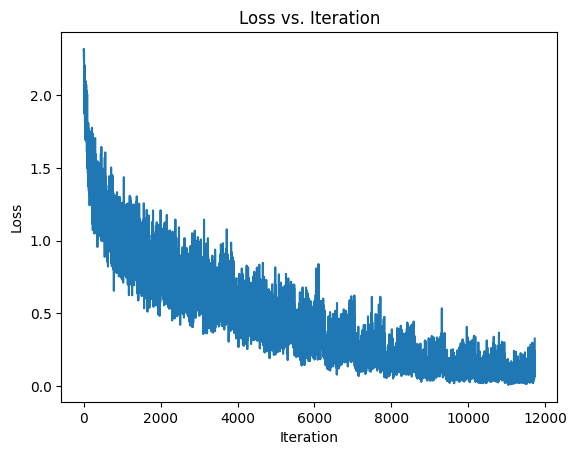

Accuracy: 0.7146, F1-score: 0.7146


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score

# Load CIFAR-10 dataset
ds = load_dataset("uoft-cs/cifar10")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Convert Hugging Face dataset to PyTorch Dataset
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["img"]
        label = self.dataset[idx]["label"]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CIFAR10Dataset(ds["train"], transform=transform)
test_dataset = CIFAR10Dataset(ds["test"], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
losses = []
iteration = 0

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        iteration += 1

    print(f"Epoch {epoch+1}/{num_epochs}, Batch Loss: {loss.item():.4f}")

# Plot loss vs. iteration
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()

# Evaluate the model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")
